In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from models.skill_extractor import SkillExtractor
from models.matcher import ResumeJobMatcher

print("✓ Imports successful")

c:\Users\klmor\resume-screener-ats\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful


In [2]:
# Load processed data
with open('../data/processed/processed_resumes.json', 'r') as f:
    resumes = json.load(f)

with open('../data/processed/processed_job_descriptions.json', 'r') as f:
    jobs = json.load(f)

print(f"Loaded {len(resumes)} resumes and {len(jobs)} job descriptions")

Loaded 3 resumes and 3 job descriptions


In [3]:
# Initialize extractor
extractor = SkillExtractor(use_large_model=False)

# Extract skills from all resumes
resume_skills_data = []

for resume in resumes:
    profile = extractor.extract_complete_profile(
        resume['raw_text'],
        resume.get('sections', {})
    )
    
    resume_skills_data.append({
        'filename': resume['filename'],
        'name': resume.get('name'),
        'skills': profile['skills']['skills'],
        'total_skills': profile['skills']['total_skills'],
        'categories': profile['skills']['categories'],
        'education': profile['education']['highest_level'],
        'experience_level': profile['experience_level'],
        'certifications': profile['certifications']
    })

print("✓ Skill extraction complete")

✓ Loaded spaCy model: en_core_web_sm
✓ Skill extraction complete


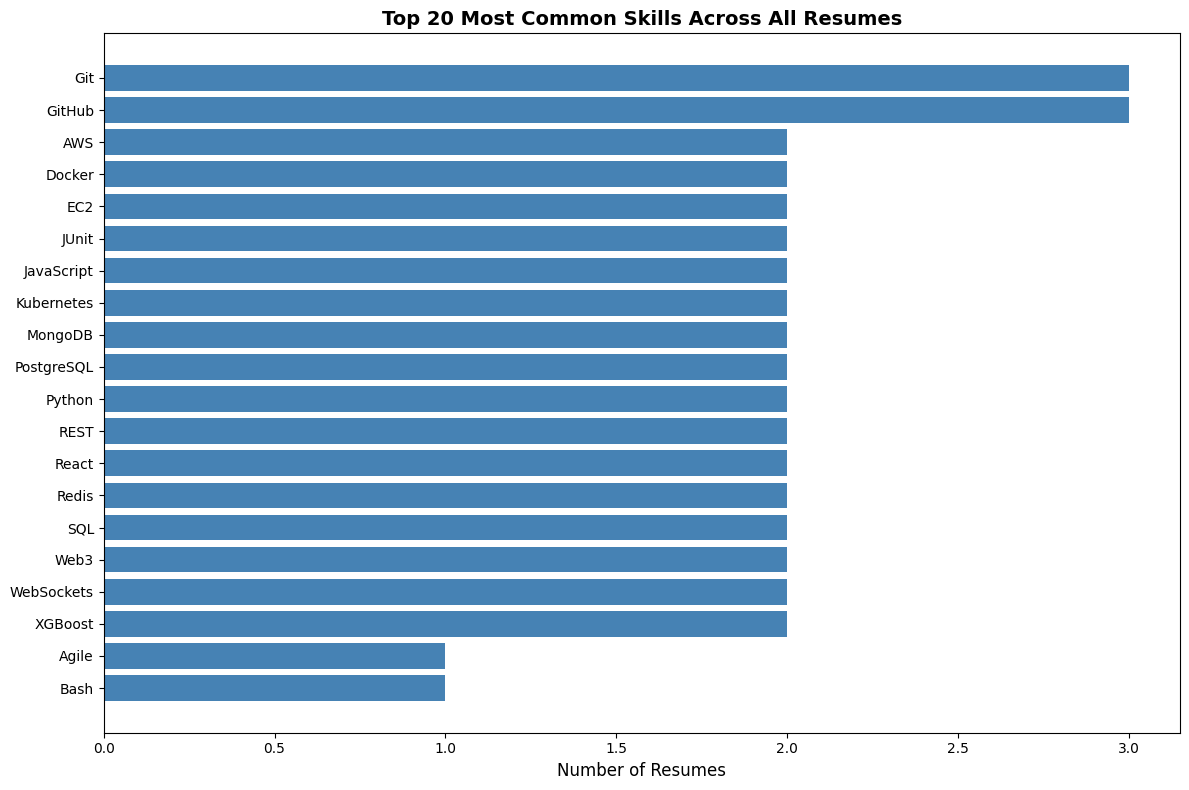

Total unique skills found: 89


In [4]:
# Count all skills across resumes
all_skills = []
for data in resume_skills_data:
    all_skills.extend(data['skills'])

skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(20)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
skills, counts = zip(*top_skills)
ax.barh(range(len(skills)), counts, color='steelblue')
ax.set_yticks(range(len(skills)))
ax.set_yticklabels(skills)
ax.set_xlabel('Number of Resumes', fontsize=12)
ax.set_title('Top 20 Most Common Skills Across All Resumes', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Total unique skills found: {len(skill_counts)}")

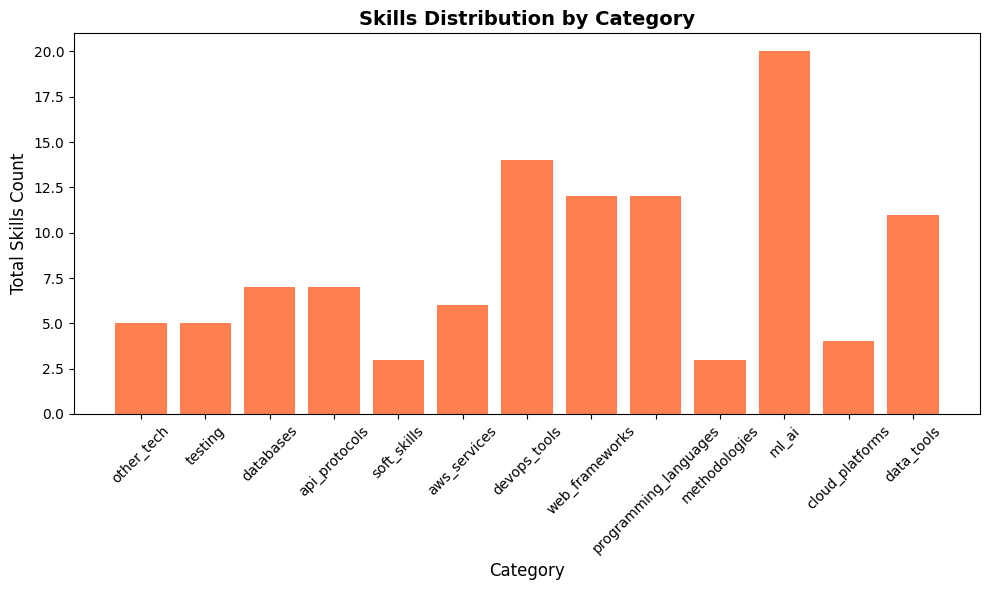

In [5]:
# Aggregate skills by category
category_counts = {}

for data in resume_skills_data:
    for category, skills in data['categories'].items():
        if category not in category_counts:
            category_counts[category] = 0
        category_counts[category] += len(skills)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
categories = list(category_counts.keys())
counts = list(category_counts.values())

ax.bar(categories, counts, color='coral')
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Total Skills Count', fontsize=12)
ax.set_title('Skills Distribution by Category', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Initialize matcher
matcher = ResumeJobMatcher(use_transformers=False)  # Faster without transformers

# Match resumes to first job
job = jobs[0]
job_profile = extractor.extract_complete_profile(job['raw_text'], job.get('sections', {}))

match_results = []

for resume in resumes:
    resume_profile = extractor.extract_complete_profile(
        resume['raw_text'],
        resume.get('sections', {})
    )
    resume_profile['filename'] = resume['filename']
    resume_profile['name'] = resume.get('name')
    resume_profile['years_experience'] = resume.get('years_experience', 0)
    resume_profile['raw_text'] = resume['raw_text']
    
    job_profile['filename'] = job['filename']
    job_profile['raw_text'] = job['raw_text']
    
    result = matcher.calculate_overall_fit_score(resume_profile, job_profile)
    
    match_results.append({
        'candidate': resume.get('name', 'Unknown'),
        'overall_score': result['overall_score'],
        'skill_match': result['skill_match']['match_percentage'],
        'text_similarity': result['text_similarity'],
        'fit_level': result['fit_level']
    })

df_matches = pd.DataFrame(match_results)
display(df_matches.sort_values('overall_score', ascending=False))

✓ Loaded spaCy model: en_core_web_sm


,candidate,overall_score,skill_match,text_similarity,fit_level
2,SARAH JOHNSON,75.92,91.67,28.34,Good
0,JOHN DOE,42.25,16.67,3.89,Fair
1,MICHAEL CHEN,38.83,8.33,3.35,Poor


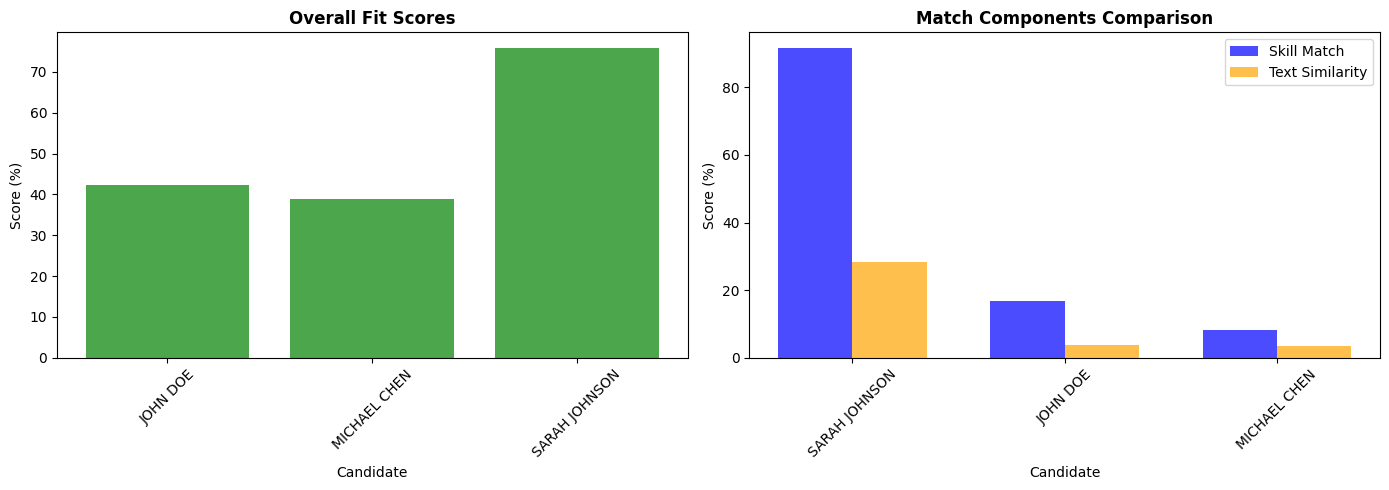

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall scores
axes[0].bar(df_matches['candidate'], df_matches['overall_score'], color='green', alpha=0.7)
axes[0].set_title('Overall Fit Scores', fontweight='bold')
axes[0].set_ylabel('Score (%)')
axes[0].set_xlabel('Candidate')
axes[0].tick_params(axis='x', rotation=45)

# Component breakdown
df_matches_sorted = df_matches.sort_values('overall_score', ascending=False)
x = range(len(df_matches_sorted))
width = 0.35

axes[1].bar([i - width/2 for i in x], df_matches_sorted['skill_match'], 
            width, label='Skill Match', color='blue', alpha=0.7)
axes[1].bar([i + width/2 for i in x], df_matches_sorted['text_similarity'], 
            width, label='Text Similarity', color='orange', alpha=0.7)

axes[1].set_title('Match Components Comparison', fontweight='bold')
axes[1].set_ylabel('Score (%)')
axes[1].set_xlabel('Candidate')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_matches_sorted['candidate'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
print("="*70)
print("PHASE 3 ANALYSIS SUMMARY")
print("="*70)

print(f"\n📊 SKILL EXTRACTION:")
print(f"  • Total unique skills found: {len(skill_counts)}")
print(f"  • Average skills per resume: {sum(d['total_skills'] for d in resume_skills_data) / len(resume_skills_data):.1f}")
print(f"  • Most common skill: {top_skills[0][0]} ({top_skills[0][1]} resumes)")

print(f"\n🎯 MATCHING:")
print(f"  • Job: {job['filename']}")
print(f"  • Best match: {df_matches.iloc[0]['candidate']} ({df_matches.iloc[0]['overall_score']:.1f}%)")
print(f"  • Average match score: {df_matches['overall_score'].mean():.1f}%")

print(f"\n✓ Phase 3 Complete - Ready for API Development")

PHASE 3 ANALYSIS SUMMARY

📊 SKILL EXTRACTION:
  • Total unique skills found: 89
  • Average skills per resume: 36.3
  • Most common skill: Git (3 resumes)

🎯 MATCHING:
  • Job: Data_Scientist.txt
  • Best match: JOHN DOE (42.2%)
  • Average match score: 52.3%

✓ Phase 3 Complete - Ready for API Development
